In [3]:
!nvidia-smi

Thu May  1 14:46:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 571.59                 Driver Version: 571.59         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A2000 12GB        WDDM  |   00000000:65:00.0  On |                  Off |
| 30%   44C    P8              7W /   70W |    1073MiB /  12282MiB |      9%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

95% > we will try to use the memory > 90% - so that not out of memory

Theoretical GFLOPs = (CUDA Cores × Clock Speed in GHz × 2)

GFLOPs = 3328 × 1.2 × 2 = **7987.2 GFLOPs** ≈ **7.99 TFLOPs** = **0.0079872 PFLOPs**

In [5]:
from tokenizers import Tokenizer

tokenizer = Tokenizer.from_file("bitext_bpe_tokenizer.json")

def get_vocab_size(tokenizer: Tokenizer) -> int:
    """
    Returns the total vocabulary size including special tokens.
    """
    vocab = tokenizer.get_vocab()
    return len(vocab)

Create the model

In [6]:
# First, let's update the GPU configuration
import torch
torch.manual_seed(3647)
torch.set_float32_matmul_precision('high')
torch._dynamo.config.suppress_errors = True 
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True  # Allow TF32 for faster matrix multiplications

In [7]:
from transformer.model import GPTLanguageModel

block_size = 256
n_embd = 512
n_head = 16
n_layer = 4
dropout = 0.2
batch_size = 128
vocab_size = get_vocab_size(tokenizer)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = GPTLanguageModel(
    vocab_size=vocab_size,
    block_size=block_size,
    n_embd=n_embd,
    n_head=n_head,
    n_layer=n_layer,
    dropout=dropout,
    device=device
).to(device)
# model = torch.compile(model)

print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

13.785088 M parameters


Data preparation

In [8]:
with open("train_sequences.txt", "r") as f:
    text_sequence = f.read()

encoded_text_sequence = tokenizer.encode(text_sequence)
len(encoded_text_sequence)

4512042

train-test-split

In [6]:
data = torch.tensor(encoded_text_sequence.ids, dtype=torch.long)

# Split into train/validation
split_index = int(0.9 * len(data))
train_data = data[:split_index]
val_data = data[split_index:]


Data Loader

In [7]:
from typing import Tuple
from torch.utils.data import Dataset, DataLoader


class TextDataset(Dataset):
    def __init__(self, data: torch.Tensor, block_size: int) -> None:
        self.data = data
        self.block_size = block_size

    def __len__(self) -> int:
        return len(self.data) - self.block_size

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        x = self.data[index:index + self.block_size]
        y = self.data[index + 1:index + self.block_size + 1]
        return x, y



def get_dataloaders(
        train_data: torch.Tensor,
        val_data: torch.Tensor,
        block_size: int,
        batch_size: int,
        device: torch.device
) -> Tuple[DataLoader, DataLoader]:
    train_dataset = TextDataset(train_data.to(device), block_size)
    val_dataset = TextDataset(val_data.to(device), block_size)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True, 
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False, 
    )

    return train_loader, val_loader


In [8]:
train_loader, val_loader = get_dataloaders(
    train_data=train_data,
    val_data=val_data,
    block_size=block_size,
    batch_size=batch_size,
    device=device
)
x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([128, 256]), torch.Size([128, 256]))

Training

In [9]:
from typing import Dict


@torch.no_grad()
def estimate_loss(
    model: torch.nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    eval_iters: int
) -> Dict[str, float]:
    output = {}
    model.eval()

    for split, loader in [('train', train_loader), ('val', val_loader)]:
        losses = torch.zeros(eval_iters)
        for i, (x, y) in enumerate(loader):
            if i >= eval_iters:
                break
            with torch.no_grad():
                _, loss = model(x, y)
            losses[i] = loss.item()
        output[split] = losses.mean().item()

    model.train()
    return output

In [10]:
def save_checkpoint(
    model: GPTLanguageModel,
    optimizer: torch.optim.Optimizer,
    epoch: int,
    loss: float,
    file_path: str = "checkpoint.pth"
) -> None:
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, file_path)

In [11]:
import time

max_iters = 1
eval_interval = 100
eval_iters = 200
learning_rate = 3e-4

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
train_loader, val_loader = get_dataloaders(
    train_data=train_data,
    val_data=val_data,
    block_size=block_size,
    batch_size=batch_size,
    device=device
)

train_losses = []
val_losses = []

for iteration in range(max_iters):
    start_time = time.time()
    total_loss = 0.0
    model.train()
    for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
        if batch_idx % eval_interval == 0 or batch_idx == len(train_loader) - 1:
            losses = estimate_loss(
                model=model,
                train_loader=train_loader,
                val_loader=val_loader,
                eval_iters=min(eval_iters, len(val_loader))
            )
            train_losses.append(losses['train'])
            val_losses.append(losses['val'])
            print(
                f"iteration {iteration} / step {batch_idx}: "
                f"train loss {losses['train']:.4f}, "
                f"val loss {losses['val']:.4f}"
            )

        logits, loss = model(x_batch, y_batch)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_epoch_loss = total_loss / len(train_loader)
    elapsed = time.time() - start_time
    print(f"Epoch {iteration + 1} average training loss: {avg_epoch_loss:.4f}")
    print(f"Epoch {iteration + 1} training time: {elapsed:.2f} seconds")

    save_checkpoint(
        model=model,
        optimizer=optimizer,
        epoch=iteration,
        loss=avg_epoch_loss,
        file_path=f"../output/pre_training/run_4/checkpoint_{iteration}.pth"
    )

iteration 0 / step 0: train loss 7.0336, val loss 7.0990
iteration 0 / step 100: train loss 2.8574, val loss 3.2870
iteration 0 / step 200: train loss 2.1408, val loss 2.4412
iteration 0 / step 300: train loss 1.5602, val loss 1.9031
iteration 0 / step 400: train loss 1.2852, val loss 1.6078
iteration 0 / step 500: train loss 1.1404, val loss 1.4414
iteration 0 / step 600: train loss 1.0565, val loss 1.3289
iteration 0 / step 700: train loss 0.9899, val loss 1.2505
iteration 0 / step 800: train loss 0.9420, val loss 1.2023
iteration 0 / step 900: train loss 0.9053, val loss 1.1487
iteration 0 / step 1000: train loss 0.8667, val loss 1.1181
iteration 0 / step 1100: train loss 0.8374, val loss 1.0889
iteration 0 / step 1200: train loss 0.8166, val loss 1.0714
iteration 0 / step 1300: train loss 0.7985, val loss 1.0537
iteration 0 / step 1400: train loss 0.7812, val loss 1.0424
iteration 0 / step 1500: train loss 0.7653, val loss 1.0244
iteration 0 / step 1600: train loss 0.7484, val loss

RuntimeError: Parent directory ../output/pre_training/run_4 does not exist.

- len(encoded_text_sequence) = 4,512,042 tokens
- So training data (90%) = 0.9 * 4,512,042 ≈ 4,060,837 tokens
- Tokens per batch = 128 * 256 = 32,768
- total_steps = 4,060,837 / 32,768 ≈ 124 steps

In [14]:
    save_checkpoint(
        model=model,
        optimizer=optimizer,
        epoch=iteration,
        loss=avg_epoch_loss,
        file_path="E:/Vivek/YugAI/output/checkpoint_1.pt"
    )

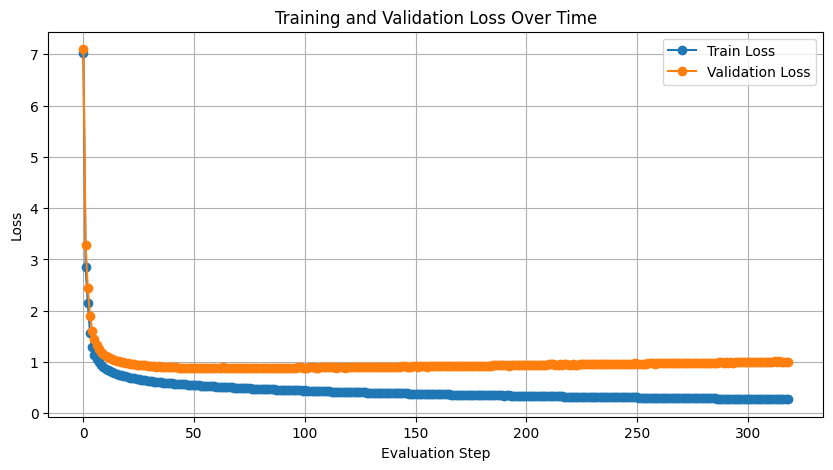

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Validation Loss", marker='o')
plt.xlabel("Evaluation Step")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Time")
plt.legend()
plt.grid()
plt.show()

In [10]:
# Encode text and extract token IDs

flag = "1"

while(flag == "1"):
    query = input("Enter you query")
    input_tokens = tokenizer.encode(query).ids

    # Convert to tensor
    input_tokens = torch.tensor(input_tokens, dtype=torch.long).unsqueeze(0).to(device)  # shape: (1, T)

    # Generate text
    model.eval()
    with torch.no_grad():
        output = model.generate(input_tokens=input_tokens, max_new_tokens=100)

    # Decode and print
    print(tokenizer.decode(output[0].tolist()))
    flag = input("Do you have another query or not 0/1")


H i reg direct don De ve gor ong associated App ️ jo reach down Click by cancel err de ok reach receive polog relevant sti bsite ple Ch ist reat indly feel there feel ized follow compens son tain gether imbur : contact ively go product Q ha z error of T Su where In assu ( get 💡 If ts enef Could ve i imb pen operation ty res 1 us lease indly sit ; 🌟 Name es ad payment confirm person ctions ef Q av elig indly changes hesitate 🙏 term bus some deli about detailed cur settings
